# Practice different ML solutions for the Bike Sharing competition
---
  
<div class="alert alert-block alert-info">
    This notebook was prepared by <b>Abed AlRahman Naser</b>.<br>
</div>
  
#### The data was taken from https://www.kaggle.com/c/bike-sharing-demand/overview

#### Description about the data: 

<span style="color:#424544">
    
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.
</span><br>

Data Fields
 * datetime - hourly date + timestamp  
 * season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
 * holiday - whether the day is considered a holiday
 * workingday - whether the day is neither a weekend nor holiday
 * weather - 
     1. Clear, Few clouds, Partly cloudy, Partly cloudy
     2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
     3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
     4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
 * temp - temperature in Celsius
 * atemp - "feels like" temperature in Celsius
 * humidity - relative humidity
 * windspeed - wind speed
 * casual - number of non-registered user rentals initiated
 * registered - number of registered user rentals initiated
 * count - number of total rentals


  
__Content of this notebook:__
1. __EDA.__
2. __Feature Engineering.__
3. __Machine Learning models.__
4. __Conclusion.__
  
> The Machine Learning Algorithms used in this notebook will be: Simple Linear Regression, Ridge Regression, K-NN.
  
---

# Let's start!
---

#### Importing needed libraries to work with the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spstats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import neighbors
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

---

#### Reading the data and taking a look on it.

In [2]:
bike_df = pd.read_csv("train.csv")
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


__The shape of the data__

In [3]:
bike_df.shape

(10886, 12)

__Finding out missing values__

In [4]:
bike_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

__The data contains no missing values.__
> It's worth mentioning that there are zero values of the wind speed. Zero wind speed means that the wind is calm. So, there is no missing data.

__Data types__

In [5]:
bike_df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

> The date datatype is object, it has to be a timeseries.

__Taking a brief look on the data statistical measurments__

In [6]:
bike_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


---

__Let's start working on the EDA and feature engineering.<br>
First, I will split the datetime into pieces so we have a more understandable data.__

In [7]:
bike_df['datetime'] = pd.to_datetime(bike_df['datetime'])
bike_df['datetime'].head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]

__Seperating the date__ (Feature Engineering)

Converting the date into pieces for feature engineering

In [8]:
bike_df['year'] = bike_df['datetime'].dt.year
bike_df['month'] = bike_df['datetime'].dt.month
bike_df['month_name'] = bike_df['datetime'].dt.month_name()
bike_df['day'] = bike_df['datetime'].dt.dayofweek
bike_df['hour'] = bike_df['datetime'].dt.hour
bike_df['daysofweek'] = bike_df['datetime'].dt.day_name()
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,month_name,day,hour,daysofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,January,5,0,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,January,5,1,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,January,5,2,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,January,5,3,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,January,5,4,Saturday


# EDA ( Explaratory Data Analysis )

## Let's see the realtionship between different features and the count.
_Let's start with the categorical features one by one._

Showing the correlation heatmap between all the features of the dataset.

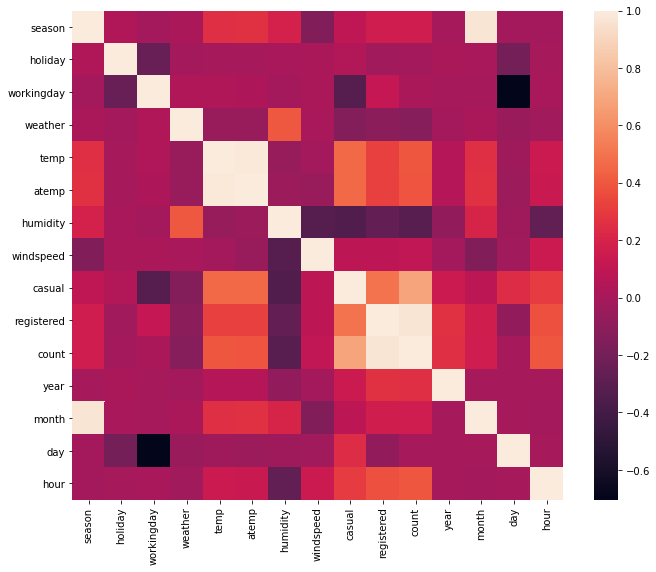

In [9]:
corr = bike_df.corr()
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(corr)


 * We can see that there is a correlation between the casual users and the temps, it looks like that casual users use bike to move in hot weather.
 * There is a high correlation between the temp and atemp. This is obviously because they are naturally highley correlated.
 * The registered users have higher correlation with the count than the casual users.

### The relationship between seasons and count

<AxesSubplot:xlabel='season', ylabel='count'>

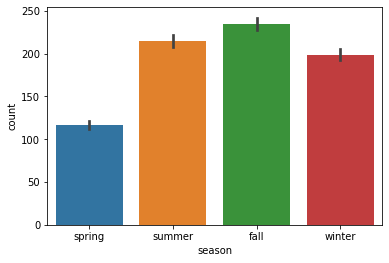

In [10]:
sns.barplot(x=bike_df['season'].replace({ 1:"spring", 2:"summer", 3:"fall", 4:"winter" }),y='count', data=bike_df)

We can see that spring is way less than the other seasons and Fall comes first.

<AxesSubplot:xlabel='holiday', ylabel='count'>

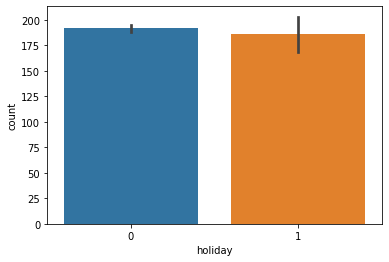

In [11]:
sns.barplot(x='holiday',y='count', data=bike_df)

People take bikes in no holidays more.

<AxesSubplot:xlabel='workingday', ylabel='count'>

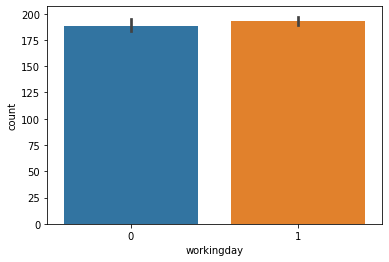

In [12]:
sns.barplot(x='workingday',y='count', data=bike_df)

People take bikes in working days more than off-days. Maybe they use it to go to work and school.

### The relationship between weather and count


<AxesSubplot:xlabel='weather', ylabel='count'>

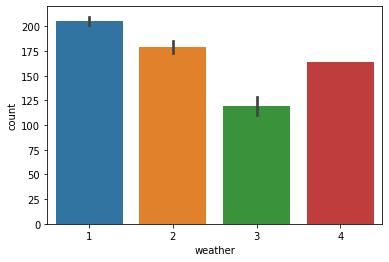

In [13]:
sns.barplot(x='weather',y='count', data=bike_df)

#### We can see that people rent bikes mostly when the weather is Clear, Few clouds, Partly cloudy, Partly cloudy.

In [14]:
bike_df[bike_df.weather==4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,month_name,day,hour,daysofweek
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,2012,1,January,0,18,Monday


---

## Relation ship between hours and count

<AxesSubplot:xlabel='hour', ylabel='count'>

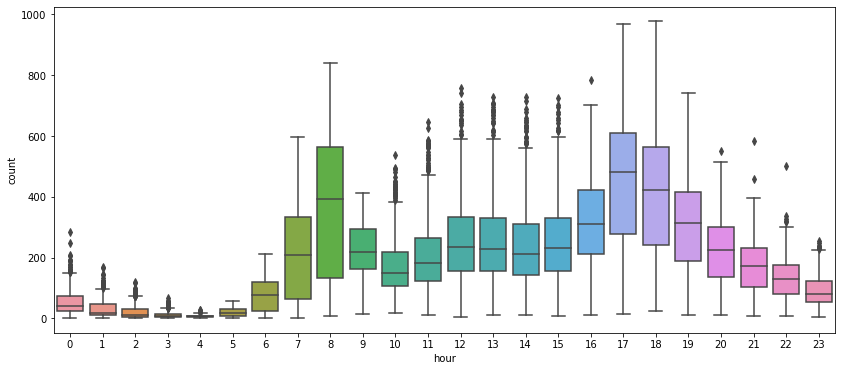

In [15]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
fig.set_size_inches(14, 6)
sns.boxplot(x='hour',y='count', data=bike_df)

It looks like that people tend to take bikes on morning between 7-9 AM when they go to school and work. Then, between 17-19 they take more bikes when they come back from their schools and work.

__Let's check out this hypothesis__

[Text(0.5, 0, 'Not holiday nor working day hours'), Text(0, 0.5, 'Count')]

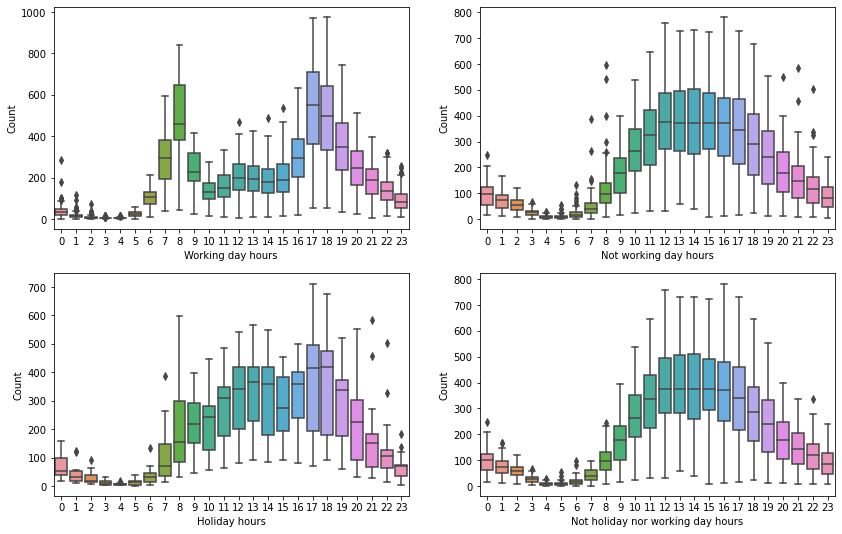

In [16]:
fig,axes_h = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(14, 9)
sns.boxplot(x='hour',y='count', data=bike_df[bike_df.workingday==1],ax=axes_h[0][0])
axes_h[0][0].set(xlabel='Working day hours', ylabel='Count')
sns.boxplot(x='hour',y='count', data=bike_df[bike_df.workingday==0],ax=axes_h[0][1])
axes_h[0][1].set(xlabel='Not working day hours', ylabel='Count')
sns.boxplot(x='hour',y='count', data=bike_df[bike_df.holiday==1],ax=axes_h[1][0])
axes_h[1][0].set(xlabel='Holiday hours', ylabel='Count')
sns.boxplot(x='hour',y='count', data=bike_df[(bike_df.holiday==0) & (bike_df.workingday==0)],ax=axes_h[1][1]
)
axes_h[1][1].set(xlabel='Not holiday nor working day hours', ylabel='Count')

 * __Our hypothesis was true about the most active hours in the working days.__
 * __As we can see for the non woking days, poeple tend to use bikes between 12 and 17.__

---

## Relationship between days and count

<AxesSubplot:xlabel='daysofweek', ylabel='count'>

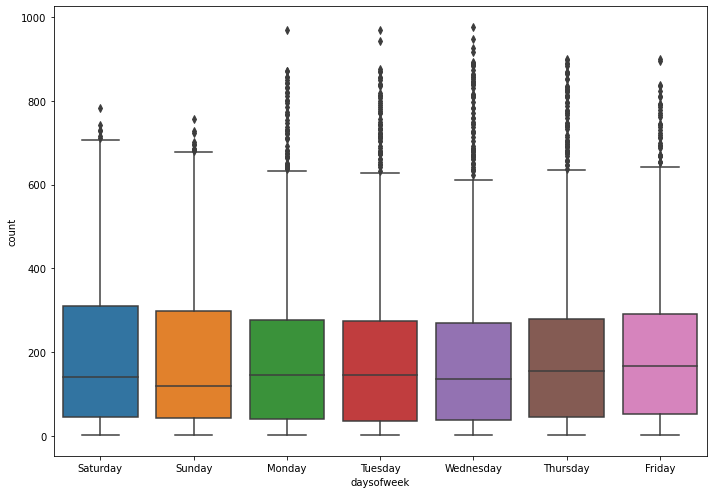

In [17]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(x='daysofweek',y='count', data=bike_df)

__It looks like people rent bikes mostly on Saturday and Friday.__

<AxesSubplot:xlabel='month_name', ylabel='count'>

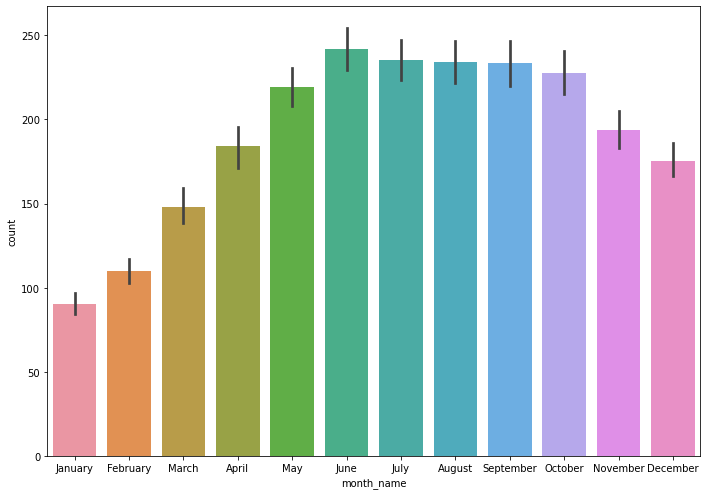

In [18]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x='month_name',y='count', data=bike_df)

__It's clear that people use bike mostly in month June, July, August and September__

### The relationship between years and count

<AxesSubplot:xlabel='year', ylabel='count'>

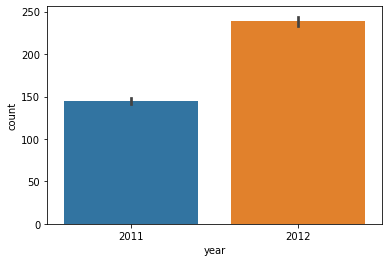

In [19]:
sns.barplot(x='year',y='count', data=bike_df)

__As we can see, the number of counts has increased significantly in the year 2012. This could mean that the number of counts of growing up with time. In year 2013 the number of counts might increase more and more because more people will be using it.__

---
### The relationship between the casual and registered users with the count

<AxesSubplot:xlabel='count', ylabel='registered'>

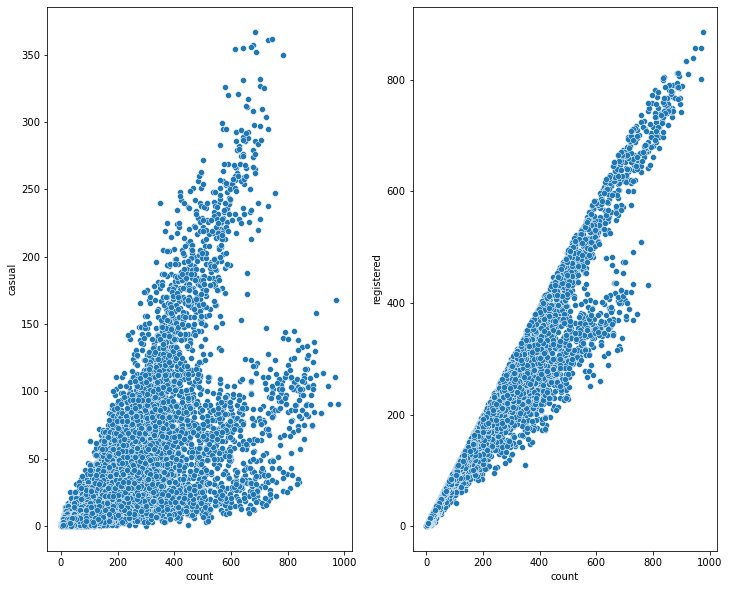

In [20]:
fig,axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 10)
sns.scatterplot(data=bike_df, x="count", y="casual",ax=axes[0])
sns.scatterplot(data=bike_df, x="count", y="registered",ax=axes[1])


__As we can see from the previous plot, the registered users have higher percentage from the casual users. Also, in the heat map we plotted earlier we can confirm this information.__

---
### Taking a look on the windspeed

<AxesSubplot:xlabel='windspeed', ylabel='count'>

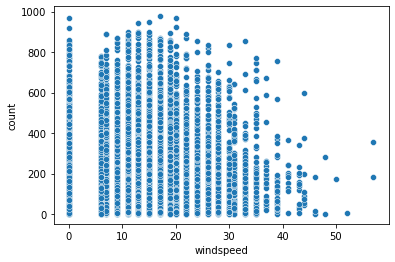

In [21]:
sns.scatterplot(data=bike_df, x="windspeed", y="count")

__It looks like that people rent bikes when the wind is calm or in medium speeds but when the speed is high (>40) they tend to be rent less than any other time.__

/home/sad/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='windspeed', ylabel='Density'>

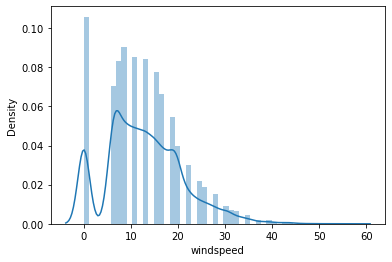

In [22]:
sns.distplot(bike_df['windspeed'])

Since the 0's are too much, we have to replace them with another valeus. Let's replace them with the mean of the windspeed.

/home/sad/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='windspeed', ylabel='Density'>

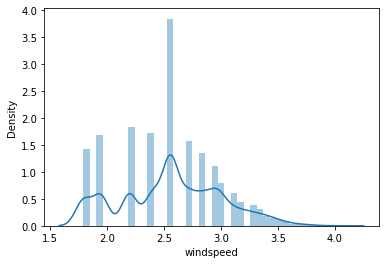

In [23]:
sns.distplot(np.log(bike_df['windspeed'].replace(0,bike_df['windspeed'].mean())))

---
### Taking a look on the count

/home/sad/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

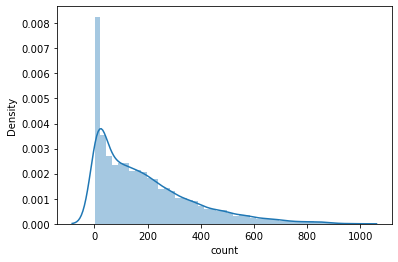

In [24]:
sns.distplot(bike_df['count'])

The count it extremely skewed to the right. Let's fix it by using the Log Transformation.

/home/sad/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

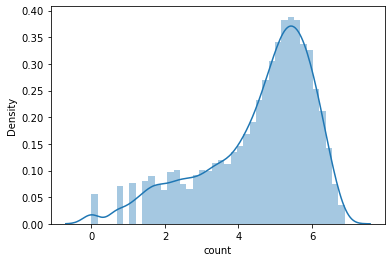

In [25]:
sns.distplot(np.log(bike_df['count']))

### Taking a look on the Humidity.

/home/sad/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='humidity', ylabel='Density'>

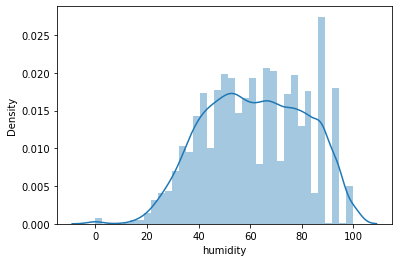

In [26]:
sns.distplot(bike_df['humidity'])

The humidity is normal-like distributed.

---
### Taking a look on temperatures
   

/home/sad/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='temp', ylabel='Density'>

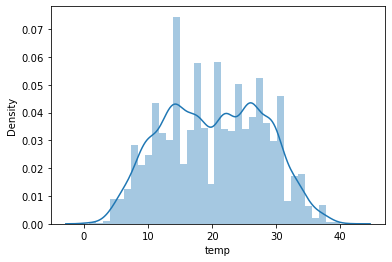

In [27]:
sns.distplot(bike_df['temp'])

/home/sad/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='atemp', ylabel='Density'>

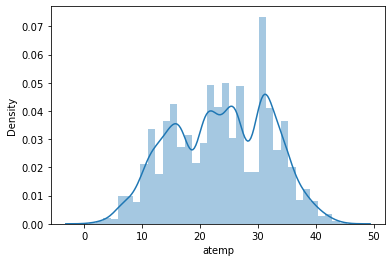

In [28]:
sns.distplot(bike_df['atemp'])

---
# More Feature Engineering
__Now we will apply Hot Encoding on the categorical features and drop some columns__  
We will drop the count, casual, registered, datetime, daysofweek.  
We dropped casual and registered becaues they are derived from the target feature.

In [29]:
eng_data = pd.get_dummies(bike_df, columns=['season','weather','day','month','hour'], drop_first=True)
eng_data['count']=np.log(eng_data['count']) # applying the Log Transformation on the count
eng_data['windspeed'] = np.log(bike_df['windspeed'].replace(0,bike_df['windspeed'].mean()))
Y = eng_data['count'] # saving the target values aside before dropping it from the dataframe
eng_data = eng_data.drop(columns=['datetime','casual','registered','count','daysofweek','month_name'])

In [41]:
eng_data

,holiday,workingday,temp,atemp,humidity,windspeed,year,season_2,season_3,season_4,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,0,9.84,14.395,81,2.549398,2011,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,9.02,13.635,80,2.549398,2011,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,9.02,13.635,80,2.549398,2011,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,9.84,14.395,75,2.549398,2011,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,9.84,14.395,75,2.549398,2011,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,1,15.58,19.695,50,3.258200,2012,0,0,1,...,0,0,0,0,0,1,0,0,0,0
10882,0,1,14.76,17.425,57,2.708137,2012,0,0,1,...,0,0,0,0,0,0,1,0,0,0
10883,0,1,13.94,15.910,61,2.708137,2012,0,0,1,...,0,0,0,0,0,0,0,1,0,0
10884,0,1,13.94,17.425,61,1.792293,2012,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## Splitting the data into training and testing data 
### The test set will be 20% of the whole data

In [30]:
X = eng_data
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=3)

---
  
# Linear Regression

__Fitting the algorithm with the training data__

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction_train=lr.predict(X_train)
prediction_test=lr.predict(X_test)

In [32]:
print("The score of the linear model on the training data: ",lr.score(X_train,y_train))

The score of the linear model on the training data:  0.8290770021827731


In [33]:
print("The score of the linear model on the test data: ",lr.score(X_test,y_test))

The score of the linear model on the test data:  0.8312385984965309


Mean Square Root Error is:  95.78178107134455


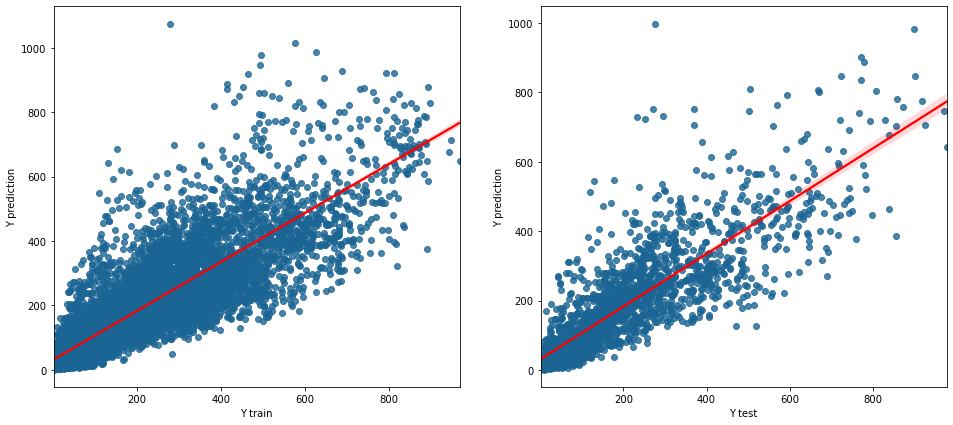

In [34]:
fig,axes = plt.subplots(ncols=2)
fig.set_size_inches(16, 7)
ax = sns.regplot(x=np.exp(y_train), y=np.exp(prediction_train),
                 scatter_kws={"color": "#1b6594"}, line_kws={"color": "red"},ax=axes[0])
axes[0].set(xlabel='Y train', ylabel='Y prediction')
ax = sns.regplot(x=np.exp(y_test), y=np.exp(prediction_test),
                 scatter_kws={"color": "#1b6594"}, line_kws={"color": "red"},ax=axes[1])
axes[1].set(xlabel='Y test', ylabel='Y prediction')
print("Mean Square Root Error is: ",sqrt(mean_squared_error(np.exp(y_test), np.exp(prediction_test))))

---
# Polynomial Features
__Let's make a polynomial from degree 2 and fit the linear model to see the results__

In [35]:
poly = PolynomialFeatures(degree = 2)
Xtrain_poly = poly.fit_transform(X_train)
Xtest_poly = poly.fit_transform(X_test)
lr.fit(Xtrain_poly,y_train)
poly_prediction_test = lr.predict(Xtest_poly)
poly_prediction_train = lr.predict(Xtrain_poly)
lr.score(Xtest_poly,y_test)

0.9523471843436752

__The Polynomial features have obviously improved the model score and made it very accurate__  
  
Plotting the predicted vs ground truth target feature for both the training and the test data.

Mean Square Root Error is:  95.78178107134455


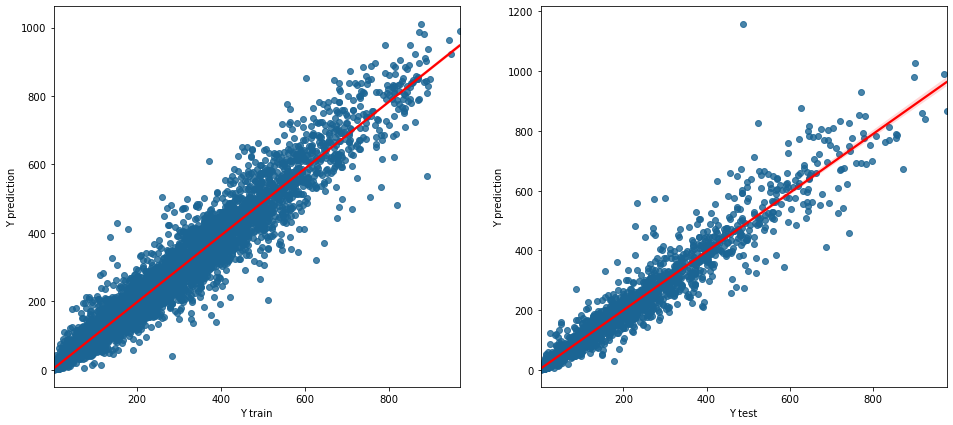

In [36]:
fig,axes = plt.subplots(ncols=2)
fig.set_size_inches(16, 7)
ax = sns.regplot(x=np.exp(y_train), y=np.exp(poly_prediction_train),
                 scatter_kws={"color": "#1b6594"}, line_kws={"color": "red"},ax=axes[0])
axes[0].set(xlabel='Y train', ylabel='Y prediction')
ax = sns.regplot(x=np.exp(y_test), y=np.exp(poly_prediction_test),
                 scatter_kws={"color": "#1b6594"}, line_kws={"color": "red"},ax=axes[1])
axes[1].set(xlabel='Y test', ylabel='Y prediction')
print("Mean Square Root Error is: ",sqrt(mean_squared_error(np.exp(y_test), np.exp(prediction_test))))

---
  
# Ridge Regression

For the ridge regression we took [ 0.001, 0.01, 1, 10, 50, 100 ] values for alpha and saw which value gives the highest accuracy.

In [37]:
rr0001 = Ridge(alpha=0.001) 
rr0001.fit(X_train, y_train)
rr = Ridge(alpha=0.01) 
rr.fit(X_train, y_train)
prediction_train = rr.predict(X_train)
prediction_test = rr.predict(X_test)
rr10 = Ridge(alpha=10)
rr10.fit(X_train, y_train)
rr1 = Ridge(alpha=1)
rr1.fit(X_train, y_train)
rr50 = Ridge(alpha=50)
rr50.fit(X_train, y_train)
rr100 = Ridge(alpha=100)
rr100.fit(X_train, y_train)
Ridge_test_score = rr0001.score(X_test, y_test)
print("Ridge score for alpha=0.001 is ",Ridge_test_score)
Ridge_test_score = rr.score(X_test, y_test)
print("Ridge score for alpha=0.01 is ",Ridge_test_score)
Ridge_test_score1 = rr1.score(X_test, y_test)
print("Ridge score for alpha=1 is ",Ridge_test_score)
Ridge_test_score10 = rr10.score(X_test, y_test)
print("Ridge score for alpha=1 is ",Ridge_test_score10)
Ridge_test_score50 = rr50.score(X_test, y_test)
print("Ridge score for alpha=50 is ",Ridge_test_score50)
Ridge_test_score100 = rr100.score(X_test, y_test)
print("Ridge score for alpha=100 is ",Ridge_test_score100)

Ridge score for alpha=0.001 is  0.8312530958102
Ridge score for alpha=0.01 is  0.8312537147463755
Ridge score for alpha=1 is  0.8312537147463755
Ridge score for alpha=1 is  0.8290740627054692
Ridge score for alpha=50 is  0.8130921933137314
Ridge score for alpha=100 is  0.7882747817496832


### __As we can see, the accuracy of ridge regression was the at its best when alpha was 0.01 and 1__

### __I will choose alpha=0.01__

Mean Square Root Error is:  96.00291785803537


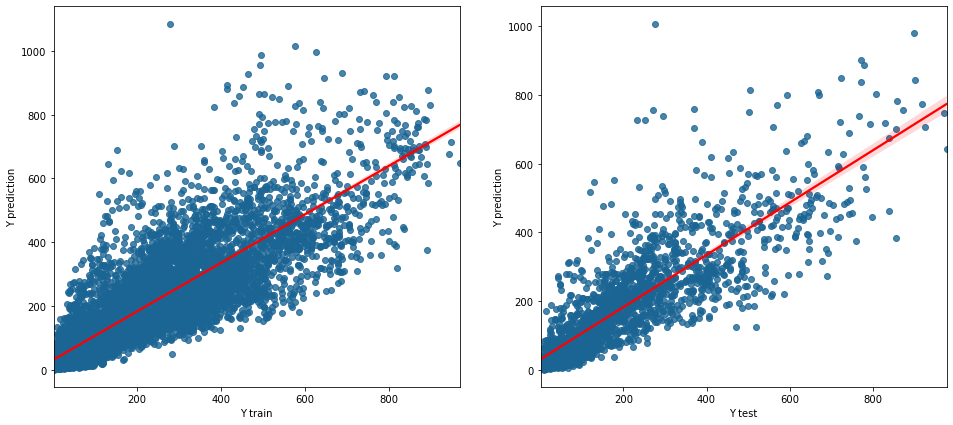

In [38]:
fig,axes = plt.subplots(ncols=2)
fig.set_size_inches(16, 7)
ax = sns.regplot(x=np.exp(y_train), y=np.exp(prediction_train),
                 scatter_kws={"color": "#1b6594"}, line_kws={"color": "red"},ax=axes[0])
axes[0].set(xlabel='Y train', ylabel='Y prediction')
ax = sns.regplot(x=np.exp(y_test), y=np.exp(prediction_test),
                 scatter_kws={"color": "#1b6594"}, line_kws={"color": "red"},ax=axes[1])
axes[1].set(xlabel='Y test', ylabel='Y prediction')
print("Mean Square Root Error is: ",sqrt(mean_squared_error(np.exp(y_test), np.exp(prediction_test))))

---

# K-NN Regression

In [39]:
knn = neighbors.KNeighborsRegressor(4)
knn.fit(X_train, y_train)
prediction_train=knn.predict(X_train)
prediction_test=knn.predict(X_test)
print("The K-NN score for the training data:",knn.score(X_train,y_train))
print("The K-NN score for the test data:",knn.score(X_test,y_test))

The K-NN score for the training data: 0.6388516828315897
The K-NN score for the test data: 0.38314078010851704


After testing multiple values for K, K=4 gave the best score for the test dataset.

Mean Square Root Error is:  149.89830521756048


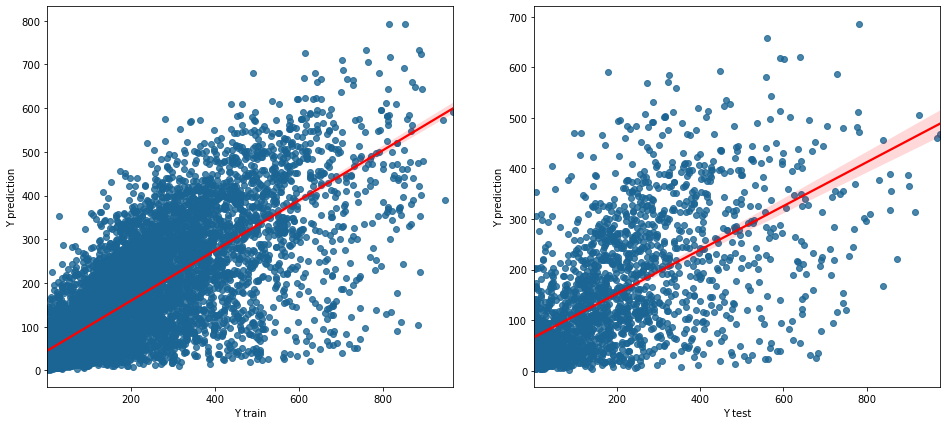

In [40]:
fig,axes = plt.subplots(ncols=2)
fig.set_size_inches(16, 7)
ax = sns.regplot(x=np.exp(y_train), y=np.exp(prediction_train),
                 scatter_kws={"color": "#1b6594"}, line_kws={"color": "red"},ax=axes[0])
axes[0].set(xlabel='Y train', ylabel='Y prediction')
ax = sns.regplot(x=np.exp(y_test), y=np.exp(prediction_test),
                 scatter_kws={"color": "#1b6594"}, line_kws={"color": "red"},ax=axes[1])
axes[1].set(xlabel='Y test', ylabel='Y prediction')
print("Mean Square Root Error is: ",sqrt(mean_squared_error(np.exp(y_test), np.exp(prediction_test))))

# Conclusion:
#### After using three different machine leaning algorithm with the Bike Sharing dataset, we found out:
 * The Polynomial Linear Regression from degree 2 was the most accurate model.
 * The K-NN Regression was the worst regression.


# Thank you for reading
